In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import torchvision
import json
import matplotlib.pyplot as plt
import os
import torch.optim as optim
from model import GoogLeNet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    "val": transforms.Compose([transforms.Resize((224, 224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}

data_root = os.path.abspath(os.path.join(os.getcwd(), "../"))  # get data root path
image_path = data_root + "/flower_data/"  # flower data set path

train_dataset = datasets.ImageFolder(root=image_path + "train",
                                     transform=data_transform["train"])
train_num = len(train_dataset)

# {'daisy':0, 'dandelion':1, 'roses':2, 'sunflower':3, 'tulips':4}
flower_list = train_dataset.class_to_idx
cla_dict = dict((val, key) for key, val in flower_list.items())
# write dict into json file
json_str = json.dumps(cla_dict, indent=4)
with open('class_indices.json', 'w') as json_file:
    json_file.write(json_str)

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size, shuffle=True,
                                           num_workers=0)

validate_dataset = datasets.ImageFolder(root=image_path + "val",
                                        transform=data_transform["val"])
val_num = len(validate_dataset)
validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=0)

# test_data_iter = iter(validate_loader)
# test_image, test_label = test_data_iter.next()

# net = torchvision.models.googlenet(num_classes=5)
# model_dict = net.state_dict()
# pretrain_model = torch.load("googlenet.pth")
# del_list = ["aux1.fc2.weight", "aux1.fc2.bias",
#             "aux2.fc2.weight", "aux2.fc2.bias",
#             "fc.weight", "fc.bias"]
# pretrain_dict = {k: v for k, v in pretrain_model.items() if k not in del_list}
# model_dict.update(pretrain_dict)
# net.load_state_dict(model_dict)

In [6]:
net = GoogLeNet(num_classes=5, aux_logits=True, init_weights=True)
net.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0003)
Loss = []
Acc = []
best_acc = 0.0
save_path = './googleNet.pth'
for epoch in range(30):
    # train
    net.train()
    running_loss = 0.0
    for step, data in enumerate(train_loader, start=0):
        images, labels = data
        optimizer.zero_grad()
        logits, aux_logits2, aux_logits1 = net(images.to(device))
        loss0 = loss_function(logits, labels.to(device))
        loss1 = loss_function(aux_logits1, labels.to(device))
        loss2 = loss_function(aux_logits2, labels.to(device))
        loss = loss0 + loss1 * 0.3 + loss2 * 0.3
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # print train process
        rate = (step + 1) / len(train_loader)
        a = "*" * int(rate * 50)
        b = "." * int((1 - rate) * 50)
        print("\rtrain loss: {:^3.0f}%[{}->{}]{:.3f}".format(int(rate * 100), a, b, loss), end="")
    print()

    # validate
    net.eval()
    acc = 0.0  # accumulate accurate number / epoch
    with torch.no_grad():
        for val_data in validate_loader:
            val_images, val_labels = val_data
            outputs = net(val_images.to(device))  # eval model only have last output layer
            predict_y = torch.max(outputs, dim=1)[1]
            acc += (predict_y == val_labels.to(device)).sum().item()
        val_accurate = acc / val_num
        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)
        Loss.append(round(running_loss / step, 3))
        Acc.append(round(val_accurate, 3))
        print("epoch:", epoch+1, "train_loss:", round(running_loss / step, 3), "test_accuracy", round(val_accurate, 3))
#         print('[epoch %d] train_loss: %.3f  test_accuracy: %.3f' %
#               (epoch + 1, running_loss / step, val_accurate))

print('Finished Training')

train loss: 100%[**************************************************->]2.308
epoch: 1 train_loss: 2.898 test_accuracy 0.53
train loss: 100%[**************************************************->]0.897
epoch: 2 train_loss: 1.779 test_accuracy 0.541
train loss: 100%[**************************************************->]1.130
epoch: 3 train_loss: 1.686 test_accuracy 0.646
train loss: 100%[**************************************************->]0.511
epoch: 4 train_loss: 1.53 test_accuracy 0.637
train loss: 100%[**************************************************->]1.518
epoch: 5 train_loss: 1.45 test_accuracy 0.681
train loss: 100%[**************************************************->]1.846
epoch: 6 train_loss: 1.369 test_accuracy 0.673
train loss: 100%[**************************************************->]1.214
epoch: 7 train_loss: 1.372 test_accuracy 0.676
train loss: 100%[**************************************************->]1.752
epoch: 8 train_loss: 1.308 test_accuracy 0.687
train loss: 100%[**

In [7]:
import matplotlib.pyplot as plt


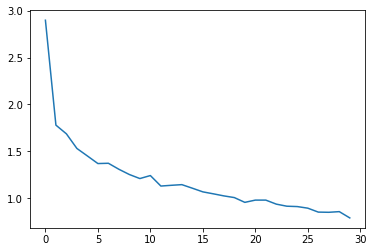

In [10]:
plt.plot(Loss)

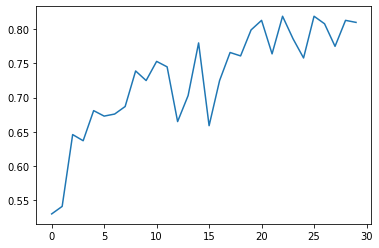

In [11]:
plt.plot(Acc)